In [26]:
import os
import torch
import numpy as np
from PIL import Image
from torchvision import models, transforms

data_dir = "D:\\Trade-Off_CBIR\\dataset\\Corel-1K"
data_dir_GHIM = "D:\\Trade-Off_CBIR\\dataset\\GHIM-10K"

print("Classes available (Corel-1K):", os.listdir(data_dir))
print("Classes available (GHIM-10K):", os.listdir(data_dir_GHIM))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Classes available (Corel-1K): ['africans', 'beaches', 'buildings', 'buses', 'dinosaurs', 'elephants', 'flowers', 'food', 'horses', 'mountains']
Classes available (GHIM-10K): ['aircraft', 'buildings', 'butterfly', 'cars', 'dragon fly', 'fireworks', 'flowers', 'hen', 'horses', 'insects', 'motorcycles', 'mountains', 'sea shores', 'ships', 'sunset', 'temples', 'trees', 'valleys', 'walls', 'yacht']
Using device: cuda


## Tahap 1: Ekstraksi Fitur Menggunakan ConvNeXt

In [27]:
efficientnet_v2 = models.efficientnet_v2_s(weights=models.EfficientNet_V2_S_Weights.DEFAULT).to(device).eval()
resnet50 = models.resnet50(weights=models.ResNet50_Weights.DEFAULT).to(device).eval()
regnet_y_400mf = models.regnet_y_400mf(weights=models.RegNet_Y_400MF_Weights.DEFAULT).to(device).eval()

# Transformasi standar untuk semua model (224x224)
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

## Tahap 2: Pre-trained Models

In [28]:
import time
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def measure_inference_speed(model, sample_img, transform, device='cuda'):
    model.eval()
    img_t = transform(sample_img).unsqueeze(0).to(device)
    torch.cuda.synchronize() if device=='cuda' else None
    start = time.time()
    with torch.no_grad():
        _ = model(img_t)
    torch.cuda.synchronize() if device=='cuda' else None
    end = time.time()
    return end - start

def get_gpu_memory_usage():
    if torch.cuda.is_available():
        return torch.cuda.max_memory_allocated() / (1024**2)
    return 0

def measure_embedding_metrics(features, labels):
    start = time.time()
    sims = cosine_similarity(features, features)
    search_time = time.time() - start
    
    inter_dists = []
    classes = list(set(labels))
    for i, cls_i in enumerate(classes):
        idx_i = [k for k,l in enumerate(labels) if l==cls_i]
        for j, cls_j in enumerate(classes):
            if i >= j:
                continue
            idx_j = [k for k,l in enumerate(labels) if l==cls_j]
            inter_dists.append(np.mean(sims[np.ix_(idx_i, idx_j)]))
    
    intra_dists = []
    for cls in classes:
        idx = [k for k,l in enumerate(labels) if l==cls]
        intra_dists.append(np.mean(sims[np.ix_(idx, idx)]))
    
    return search_time, np.mean(inter_dists), np.mean(intra_dists)


In [29]:
from tqdm import tqdm
import torch
import numpy as np
from PIL import Image
import os
from sklearn.preprocessing import normalize  # untuk L2-normalisasi

img_paths = []
labels = []

for cls in os.listdir(data_dir):
    cls_path = os.path.join(data_dir, cls)
    for f in os.listdir(cls_path):
        img_paths.append(os.path.join(cls_path, f))
        labels.append(cls)

# ===============================
# Modifikasi RegNet untuk output feature vector
# ===============================
regnet_y_400mf.fc = torch.nn.Identity()  # type: ignore # hapus classifier

# ===============================
# Ekstraksi fitur pre-trained CNN (pre-classifier) + normalisasi
# ===============================
efficientnet_features = []
regnet_features = []
resnet50_features = []

for path in tqdm(img_paths, desc="Extracting CNN Features"):
    img = Image.open(path).convert('RGB')
    img_t = transform(img).unsqueeze(0).to(device)  # type: ignore

    with torch.no_grad():
        # ---------- EfficientNet V2 Small ----------
        ef_x = efficientnet_v2.features(img_t)
        ef_x = torch.nn.functional.adaptive_avg_pool2d(ef_x, 1)
        ef_x = torch.flatten(ef_x, 1)
        efficientnet_features.append(ef_x.squeeze().cpu().numpy())

        # ---------- RegNet_Y_400MF ----------
        rg_x = regnet_y_400mf(img_t)  # langsung output feature vector
        regnet_features.append(rg_x.squeeze().cpu().numpy())

        # ---------- ResNet50 ----------
        r50_x = resnet50.conv1(img_t)
        r50_x = resnet50.bn1(r50_x)
        r50_x = resnet50.relu(r50_x)
        r50_x = resnet50.maxpool(r50_x)
        r50_x = resnet50.layer1(r50_x)
        r50_x = resnet50.layer2(r50_x)
        r50_x = resnet50.layer3(r50_x)
        r50_x = resnet50.layer4(r50_x)
        r50_x = resnet50.avgpool(r50_x)
        r50_x = torch.flatten(r50_x, 1)
        resnet50_features.append(r50_x.squeeze().cpu().numpy())

# Convert ke numpy array
efficientnet_features = np.array(efficientnet_features)
regnet_features = np.array(regnet_features)
resnet50_features = np.array(resnet50_features)

# ===============================
# L2-normalisasi fitur
# ===============================
efficientnet_features = normalize(efficientnet_features)
regnet_features = normalize(regnet_features)
resnet50_features = normalize(resnet50_features)


Extracting CNN Features: 100%|██████████| 1000/1000 [00:45<00:00, 21.93it/s]


## Tahap 3: Image Retrieval & Similarity Matching

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import numpy as np

# ===============================
# Fungsi retrieve top-K berdasarkan cosine similarity
# ===============================
def retrieve(query_feat, all_feats, top_k=10):
    sims = cosine_similarity([query_feat], all_feats)[0]  # type: ignore
    idxs = np.argsort(sims)[::-1][:top_k]
    return idxs

# ===============================
# Fungsi evaluasi Recall@K & Precision@K per kelas
# ===============================
def evaluate_recall_precision(features, labels, top_k=10):
    """
    features: numpy array, shape = (N, dim_feature)
    labels: list of length N
    top_k: int, jumlah top retrieved images
    """
    classes = sorted(list(set(labels)))
    results = []

    for cls in classes:
        # indeks query untuk kelas tertentu
        idxs_cls = [i for i, l in enumerate(labels) if l == cls]
        R_list, P_list = [], []

        for q in idxs_cls:
            retrieved_idx = retrieve(features[q], features, top_k)
            retrieved_labels = [labels[i] for i in retrieved_idx]

            # Recall = jumlah retrieved benar / total data kelas
            R = retrieved_labels.count(cls) / len(idxs_cls)
            # Precision = jumlah retrieved benar / top_k
            P = retrieved_labels.count(cls) / top_k

            R_list.append(R)
            P_list.append(P)

        results.append([cls, np.mean(R_list), np.mean(P_list)])

    df = pd.DataFrame(results, columns=['Class','R','P'])
    
    # Tambahkan row Mean keseluruhan
    mean_row = {
        'Class': 'Mean',
        'R': df['R'].mean(),
        'P': df['P'].mean()
    }
    df = pd.concat([df, pd.DataFrame([mean_row])], ignore_index=True)
    
    # Format angka 4 desimal
    df['R'] = df['R'].astype(float).map("{:.4f}".format)
    df['P'] = df['P'].astype(float).map("{:.4f}".format)

    return df

In [30]:
sample_img = Image.open(img_paths[0]).convert('RGB')

ef_time = measure_inference_speed(efficientnet_v2, sample_img, transform, device)
rg_time = measure_inference_speed(regnet_y_400mf, sample_img, transform, device)
r50_time = measure_inference_speed(resnet50, sample_img, transform, device)

gpu_mem = get_gpu_memory_usage()

ef_search, ef_inter, ef_intra = measure_embedding_metrics(efficientnet_features, labels)
rg_search, rg_inter, rg_intra = measure_embedding_metrics(regnet_features, labels)
r50_search, r50_inter, r50_intra = measure_embedding_metrics(resnet50_features, labels)

import pandas as pd

df_metrics = pd.DataFrame({
    'Model': ['EfficientNet V2', 'RegNet Y 400MF', 'ResNet50'],
    'Inference speed (s/img)': [ef_time, rg_time, r50_time],
    'GPU memory (MB)': [gpu_mem, gpu_mem, gpu_mem],
    'Embedding search time (s)': [ef_search, rg_search, r50_search],
    'Inter-class dist': [ef_inter, rg_inter, r50_inter],
    'Intra-class dist': [ef_intra, rg_intra, r50_intra]
})

display(df_metrics)


,Model,Inference speed (s/img),GPU memory (MB),Embedding search time (s),Inter-class dist,Intra-class dist
0,EfficientNet V2,0.073957,319.231445,0.029331,0.032142,0.514511
1,RegNet Y 400MF,0.009328,319.231445,0.012066,0.400905,0.698839
2,ResNet50,0.006726,319.231445,0.054590,0.134794,0.557569


In [ ]:
# ===============================
# Evaluasi CBIR / Retrieval hanya menggunakan model CNN terbaru
# ===============================
df_effnet = evaluate_recall_precision(efficientnet_features, labels)
df_regnet = evaluate_recall_precision(regnet_features, labels)
df_resnet50 = evaluate_recall_precision(resnet50_features, labels)

# Membuat tabel per kelas
df_table = pd.DataFrame()
df_table['Class'] = sorted(list(set(labels)))  # daftar kelas unik

df_table['EfficientNet V2 R'] = df_effnet['R'].astype(float)
df_table['EfficientNet V2 P'] = df_effnet['P'].astype(float)

df_table['RegNet Y 400MF R'] = df_regnet['R'].astype(float)
df_table['RegNet Y 400MF P'] = df_regnet['P'].astype(float)

df_table['ResNet50 R'] = df_resnet50['R'].astype(float)
df_table['ResNet50 P'] = df_resnet50['P'].astype(float)

# MEAN per kolom
mean_row = {
    'Class': 'Mean',
    'EfficientNet V2 R': df_table['EfficientNet V2 R'].mean(),
    'EfficientNet V2 P': df_table['EfficientNet V2 P'].mean(),
    'RegNet Y 400MF R': df_table['RegNet Y 400MF R'].mean(),
    'RegNet Y 400MF P': df_table['RegNet Y 400MF P'].mean(),
    'ResNet50 R': df_table['ResNet50 R'].mean(),
    'ResNet50 P': df_table['ResNet50 P'].mean(),
}

df_table = pd.concat([df_table, pd.DataFrame([mean_row])], ignore_index=True)

# Format angka 4 desimal (setelah semua mean dihitung)
for col in df_table.columns[1:]:
    df_table[col] = df_table[col].map("{:.4f}".format)

# Tampilkan tabel
display(df_table)


,Class,EfficientNet V2 R,EfficientNet V2 P,RegNet Y 400MF R,RegNet Y 400MF P,ResNet50 R,ResNet50 P
0,africans,0.0878,0.8780,0.0913,0.9130,0.0915,0.9150
1,beaches,0.0967,0.9670,0.0955,0.9550,0.0934,0.9340
2,buildings,0.0956,0.9560,0.0958,0.9580,0.0961,0.9610
3,buses,0.1000,1.0000,0.1000,1.0000,0.1000,1.0000
4,dinosaurs,0.1000,1.0000,0.1000,1.0000,0.1000,1.0000
5,elephants,0.1000,1.0000,0.1000,1.0000,0.1000,1.0000
6,flowers,0.1000,1.0000,0.0999,0.9990,0.1000,1.0000
7,food,0.0991,0.9910,0.0983,0.9830,0.0996,0.9960
8,horses,0.0999,0.9990,0.0999,0.9990,0.1000,1.0000
9,mountains,0.0994,0.9940,0.0987,0.9870,0.0983,0.9830


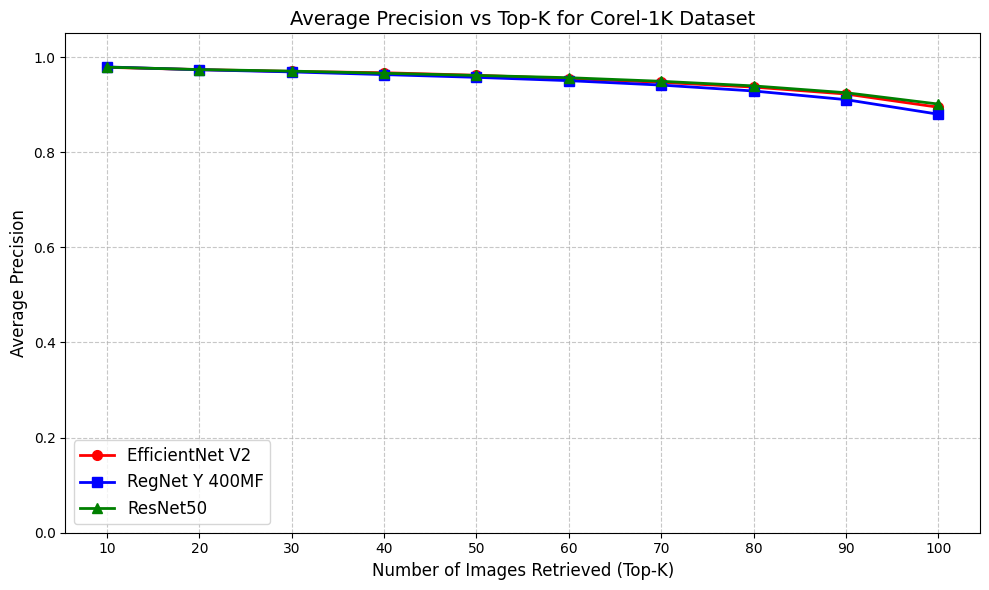

In [25]:
import matplotlib.pyplot as plt

def average_precision_vs_topk(features_list, labels, top_k_max=100):
    top_ks = list(range(10, top_k_max + 1, 10))
    avg_prec = {name: [] for name in features_list}

    # Hitung Average Precision untuk setiap Top-K
    for top_k in top_ks:
        for name, feats in features_list.items():
            df = evaluate_recall_precision(feats, labels, top_k=top_k)
            
            # Pastikan kolom 'P' float
            df['P'] = df['P'].astype(float)
            
            avg_prec[name].append(df['P'].mean())

    plt.figure(figsize=(10, 6))

    # Marker dan warna per model
    markers = {
        'EfficientNet V2': 'o',
        'RegNet Y 400MF': 's',
        'ResNet50': '^'
    }

    colors = {
        'EfficientNet V2': 'red',
        'RegNet Y 400MF': 'blue',
        'ResNet50': 'green'
    }

    # Plot Average Precision vs Top-K
    for name in features_list:
        plt.plot(top_ks, avg_prec[name],
                 marker=markers.get(name, 'o'),
                 color=colors.get(name, 'black'),
                 linestyle='-',
                 linewidth=2,
                 markersize=7,
                 label=name)

    plt.xlabel("Number of Images Retrieved (Top-K)", fontsize=12)
    plt.ylabel("Average Precision", fontsize=12)
    plt.title("Average Precision vs Top-K for Corel-1K Dataset", fontsize=14)
    plt.xticks(top_ks)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=12)
    plt.ylim(0, 1.05)
    plt.tight_layout()
    plt.show()

# Dictionary fitur terbaru
features_dict = {
    'EfficientNet V2': efficientnet_features,
    'RegNet Y 400MF': regnet_features,
    'ResNet50': resnet50_features
}

# Jalankan evaluasi dan plot
average_precision_vs_topk(features_dict, labels, top_k_max=100)
